# load

> Module for loading result from other software

In [ ]:
#| default_exp cli/load

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
import moraine.cli as mc

In [ ]:
#| export
import glob
from pathlib import Path
import tempfile
import re
import os
import logging
import math
import toml
import zarr
import time

import numpy as np
import numba
import pandas as pd
from scipy.constants import speed_of_light
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress

import moraine as mr
from moraine.gamma_ import read_gamma_image, write_gamma_image, read_gamma_plist, write_gamma_plist
from moraine.cli.logging import mc_logger
from moraine.cli import dask_from_zarr, dask_to_zarr

In [ ]:
#| export
def _rdc_width_nlines(image_par):
    """get slc width and number of lines.
    """
    with open(image_par) as f:
        for line in f:
            if re.search('range_samples',line):
                rdc_width = int(line.split()[1])
            if re.search('azimuth_lines',line):
                rdc_nlines = int(line.split()[1])
    return rdc_width, rdc_nlines

In [ ]:
#| export
def _geo_width_nlines(dem_par):
    """get dem width and number of lines.
    """
    with open(dem_par) as f:
        for line in f:
            if re.search('width',line):
                geo_width = int(line.split()[1])
            if re.search('nlines',line):
                geo_nlines = int(line.split()[1])
    return geo_width, geo_nlines

In [ ]:
#| export
def _cor_pos_dem(dem_par):
    """get corner lat and lon and post lat and lon
    """
    with open(dem_par) as f:
        for line in f:
            if re.search('corner_lat',line):
                cor_lat = float(line.split()[1])
            if re.search('corner_lon',line):
                cor_lon = float(line.split()[1])
            if re.search('post_lat',line):
                pos_lat = float(line.split()[1])
            if re.search('post_lon',line):
                pos_lon = float(line.split()[1])
    return cor_lat, cor_lon, pos_lat, pos_lon

In [ ]:
#| export
def _fetch_slc_par_date(rslc_dir,# str / Path
                       ):
    rslc_dir = Path(rslc_dir)
    rslcs = []
    rslc_pars = []
    dates = []
    for rslc in sorted(rslc_dir.glob('*.rslc')):
        rslc_par = rslc.parent / (rslc.name + '.par')
        assert rslc_par.exists(), f'{str(rslc_par)} not exists!'
        date = rslc.stem

        rslcs.append(rslc)
        rslc_pars.append(rslc_par)
        dates.append(date)
    rslcs_df = pd.DataFrame({'date':dates,'rslc':rslcs,'par':rslc_pars})
    return rslcs_df

In [ ]:
#| export
@numba.jit(nopython=True, cache=True,parallel=True,nogil=True)
def _flatten_rslc(sim_orb,rslc):
    y = np.empty(rslc.shape, rslc.dtype)
    for i in numba.prange(len(rslc)):
        y[i] = np.exp(sim_orb[i]*1j)*rslc[i]
    return y

In [ ]:
#| hide
# # since kvikio do not support read big endian data, there is no
# # need to flattening rslc with cupy

# @numba.jit(nopython=True, cache=True,parallel=True,nogil=True)
# def _flatten_rslc_numba(sim_orb,rslc):
#     y = np.empty(rslc.shape, rslc.dtype)
#     for i in numba.prange(len(rslc)):
#         y[i] = np.exp(sim_orb[i]*1j)*rslc[i]
#     return y

# @cp.fuse
# def _flatten_rslc_cupy(sim_orb,rslc):
#     return cp.exp(sim_orb*1j)*rslc

# def get_array_module(arr):
#     try:
#         import cupy as cp
#         xp = cp.get_array_module(arr)
#     except ImportError:
#         import numpy as np
#         xp = np
#     return xp

# def _flatten_rslc(sim_orb,rslc):
#     xp = get_array_module(sim_orb)
#     if xp is np:
#         return _flatten_rslc_numba(sim_orb,rslc)
#     else:
#         return _flatten_rslc_cupy_(sim_orb,rslc)

In [ ]:
#| export
@mc_logger
def load_gamma_flatten_rslc(
    rslc_dir:str, # gamma rslc directory, the name of the rslc and their par files should be '????????.rslc' and '????????.rslc.par'
    reference:str, # reference date, eg: '20200202'
    hgt:str, # the DEM in radar coordinate
    scratch_dir:str, # directory for preserve gamma intermediate files
    rslc:str, # output, the flattened rslcs stack in zarr format
    chunks:tuple[int,int]=(1000,1000), # rslc chunk size
    processes=False, # use process for dask worker or thread
    n_workers=1, # number of dask worker
    threads_per_worker=1, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''Generate flatten rslc data from gamma command and convert them into zarr format.
    The shape of hgt should be same as one rslc image, i.e. the hgt file is generated with 1 by 1 look geocoding.
    All data equal to 0 are replaced with nan.
    '''
    logger = logging.getLogger(__name__)
    rslc_path = rslc
    rslcs = _fetch_slc_par_date(rslc_dir)
    with pd.option_context('display.max_colwidth', 0):
        logger.info('rslc found: \n'+str(rslcs))
    rslc_pars = rslcs['par'].to_list()
    dates = rslcs['date'].to_list()
    rslcs = rslcs['rslc'].to_list()

    reference_idx = dates.index(reference)
    ref_rslc = rslcs[reference_idx]
    ref_rslc_par = rslc_pars[reference_idx]
    hgt = Path(hgt)

    n_image = len(rslcs)
    width,nlines = _rdc_width_nlines(ref_rslc_par)
    az_chunk_size, r_chunk_size = chunks
    logger.info(f'number of images: {n_image}.')
    logger.info(f'image number of lines: {nlines}.')
    logger.info(f'image width: {width}.')

    logger.info('run gamma command to generate required data for flattened rslcs:')
        
    scratch_dir = Path(scratch_dir)
    scratch_dir.mkdir(exist_ok=True)
    sim_orbs = []
    for i,(date,rslc,rslc_par) in enumerate(zip(dates,rslcs,rslc_pars)):
        off_par = scratch_dir/(reference+'_'+date+'.off')
        create_offset_command = f'create_offset {str(ref_rslc_par)} {str(rslc_par)} {str(off_par)} 1 1 1 0 >> {str(scratch_dir/"gamma.log")}'
        logger.info('run command: ' + create_offset_command)
        os.system(create_offset_command)
        sim_orb = scratch_dir/(reference+'_'+date+'.sim_orb')
        phase_sim_orb_command = f'phase_sim_orb {str(ref_rslc_par)} {str(rslc_par)} {str(off_par)} {str(hgt)} {str(sim_orb)} {str(ref_rslc_par)} - - 1 1 >> {str(scratch_dir/"gamma.log")}'
        if sim_orb.exists():
            logger.info(f'{sim_orb} exists. skip runing {phase_sim_orb_command}')
        else:
            logger.info('run command: ' + phase_sim_orb_command)
            os.system(phase_sim_orb_command)
        sim_orbs.append(sim_orb)
    logger.info('gamma command finished.')
    logger.info('using dask to load data in gamma binary format to calculate flatten rslcs and save it to zarr.')
    logger.info('starting dask local cluster.')
    with LocalCluster(processes=processes, n_workers=n_workers, threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        read_gamma_image_delayed = delayed(read_gamma_image, pure=True)

        # n_az_chunk = math.ceil(nlines/az_chunk_size)
        # lazy_rslcs = np.empty((n_az_chunk,1,n_image),dtype=object)
        # lazy_sim_orbs = np.empty((n_az_chunk,1,n_image),dtype=object)
        # lazy_flatten_rslcs = np.empty_like(lazy_rslcs)
        # for k, rslc in enumerate(rslcs):
        #     for i in range(n_az_chunk):
        #         y0 = i*az_chunk_size
        #         ny =  nlines-y0 if (i == n_az_chunk-1) else az_chunk_size 
        #         lazy_rslcs[i,0,k] = read_gamma_image_delayed(rslc,width,dtype='fcomplex',y0=y0,ny=ny)
        #         lazy_sim_orbs[i,0,k] = read_gamma_image_delayed(sim_orbs[k],width, dtype='float',y0=y0,ny=ny)
        #         lazy_flatten_rslcs[i,0,k] = delayed(_flatten_rslc,pure=True,nout=1)(lazy_sim_orbs[i,0,k],lazy_rslcs[i,0,k])
        #         lazy_flatten_rslcs[i,0,k] = (da.from_delayed(lazy_flatten_rslcs[i,0,k],shape=(ny,width),meta=np.array((),dtype=np.complex64))).reshape(ny,width,1)
        # flatten_rslcs_data = da.block(lazy_flatten_rslcs.tolist())

        lazy_rslcs = np.empty((1,1,n_image),dtype=object)
        lazy_sim_orbs = np.empty((1,1,n_image),dtype=object)
        lazy_flatten_rslcs = np.empty_like(lazy_rslcs)
        for k, rslc in enumerate(rslcs):
            lazy_rslcs[0,0,k] = read_gamma_image_delayed(rslc,width,dtype='fcomplex')
            lazy_sim_orbs[0,0,k] = read_gamma_image_delayed(sim_orbs[k],width, dtype='float')
            lazy_flatten_rslcs[0,0,k] = delayed(_flatten_rslc,pure=True,nout=1)(lazy_sim_orbs[0,0,k],lazy_rslcs[0,0,k])
            lazy_flatten_rslcs[0,0,k] = (da.from_delayed(lazy_flatten_rslcs[0,0,k],shape=(nlines,width),meta=np.array((),dtype=np.complex64))).reshape(nlines,width,1)
        flatten_rslcs_data = da.block(lazy_flatten_rslcs.tolist())

        logger.darr_info('flattened rslc', flatten_rslcs_data)
        _flatten_rslcs_data = dask_to_zarr(flatten_rslcs_data,rslc_path,chunks=(*chunks,1))
        #_flatten_rslcs_data = flatten_rslcs_data.to_zarr(rslc_zarr,overwrite=True,compute=False)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_flatten_rslcs_data)
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
        time.sleep(0.1) 
        #when progresses=False with progress, there is always asyncio.exceptions.CancelledError
        # use sleep to temporally stop it
    logger.info('dask cluster closed.')

The method behind the flattened RSLC:

Let the value of i-th rslc be $s_i$, the simulated phase due to DEM and position difference be $u_{ij}$.
D-InSAR basically is:
$$d_{ij}=s_i \times s_j^* \times e^{-ju_{ij}}.$$
Let the distance between satellite and ground target for th i-th observation be $l_i$.
Then, the simulated phase for DInSAR
$$u_{ij} = l_i-l_j.$$
So, a simple conclusion is $$u_{ij}-u_{ik}=-u_{jk}.$$
If we define $$s_i^{\prime} = s_i \times e^{ju_{xi}},$$
where $X$ can be any arbitrary interger less than $N$- the total number of the RSLCs.
Then we can find that
$$int_{ij}^{\prime} =  s_i^{\prime} \times s_j^{\prime*} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{-ju_{ij}} = d_{ij}.$$

We call $s_i^{\prime}$ as flattened RSLC.
The advantage of flattened RSLC is DInSAR can be easily calculated by simple conjugate multiplication.

An example:

In [ ]:
rslc_dir = '../../data/gamma/rslc'
reference = '20220620'
hgt = '../../data/gamma/geocoding/20210802.hgt'
rslc = './raw/rslc.zarr'
scratch_dir = './raw/scratch'

In [ ]:
logger = mc.get_logger()

In [ ]:
load_gamma_flatten_rslc(rslc_dir,reference,hgt,scratch_dir,rslc,chunks=(1000,1000))

2025-09-18 12:15:20 - log_args - INFO - running function: load_gamma_flatten_rslc
2025-09-18 12:15:20 - log_args - INFO - fetching args:
2025-09-18 12:15:20 - log_args - INFO - rslc_dir = '../../data/gamma/rslc'
2025-09-18 12:15:20 - log_args - INFO - reference = '20220620'
2025-09-18 12:15:20 - log_args - INFO - hgt = '../../data/gamma/geocoding/20210802.hgt'
2025-09-18 12:15:20 - log_args - INFO - scratch_dir = './raw/scratch'
2025-09-18 12:15:20 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-09-18 12:15:20 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:15:20 - log_args - INFO - processes = False
2025-09-18 12:15:20 - log_args - INFO - n_workers = 1
2025-09-18 12:15:20 - log_args - INFO - threads_per_worker = 1
2025-09-18 12:15:20 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:15:20 - log_args - INFO - fetching args done.
2025-09-18 12:15:20 - load_gamma_flatten_rslc - INFO - rslc found: 
        date                                 rslc  \
0   20210802  ../../da

In [ ]:
#| export
@mc_logger
def load_gamma_lat_lon_hgt(diff_par:str, # geocoding diff_par,using the simulated image as reference
                           rslc_par:str, # par file of the reference rslc
                           dem_par:str, # dem par
                           hgt:str, # DEM in radar coordinate
                           scratch_dir:str, # directory for preserve gamma intermediate files
                           lat_zarr:str, # output, latitude zarr
                           lon_zarr:str, # output, longitude zarr
                           hgt_zarr:str, # output, height zarr
                           chunks:tuple[int,int]=(1000,1000), # rslc chunk size
                          ):
    '''
    Function to load longitude and latitude from gamma binary format to zarr.
    All data equal to 0 are replaced with nan.
    '''
    logger = logging.getLogger(__name__)
    geo_width = _geo_width_nlines(dem_par)[0]
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')

    lat_data = zarr.open(lat_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float64)
    lon_data = zarr.open(lon_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float64)
    hgt_data = zarr.open(hgt_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float32)

    scratch_dir = Path(scratch_dir)
    scratch_dir.mkdir(exist_ok=True)
    logger.info('run gamma command to generate longitude, latitude and height:')

    plist = scratch_dir/'plist'
    command =f"mkgrid {str(plist)} {rdc_width} {rdc_nlines} 1 1 >> {str(scratch_dir/'gamma.log')}"
    if plist.exists():
        logger.info(f'{plist} exists. skip runing {command}')
    else:
        # pt_i = np.arange(rdc_width,dtype=np.int32)
        # pt_j = np.arange(rdc_nlines,dtype=np.int32)
        # pt_ii,pt_jj = np.meshgrid(pt_i,pt_j)
        # pt_ij = np.stack((pt_ii,pt_jj),axis=-1)
        # write_gamma_plist(pt_ij,scratch_dir/'plist')
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')

    phgt_wgs84 = scratch_dir/'phgt_wgs84'
    command = f"pt2geo {str(plist)} - {rslc_par} - {hgt} {dem_par} {diff_par} 1 1 - - {str(scratch_dir/'plat_lon')} {str(phgt_wgs84)} >> {str(scratch_dir/'gamma.log')}"
    if phgt_wgs84.exists():
        logger.info(f'{phgt_wgs84} exists. skip runing {command}')
    else:
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
    logger.info('writing zarr file.')
    hgt_data[:] = read_gamma_image(str(phgt_wgs84),width=rdc_width,dtype='float')

    ptlonlat = read_gamma_plist(str(scratch_dir/'plat_lon'),dtype='double').reshape(rdc_nlines, rdc_width, 2)
    lon_data[:], lat_data[:] = ptlonlat[...,0], ptlonlat[...,1]
    logger.info('write done.')

In [ ]:
diff_par = '../../data/gamma/geocoding/20210802.diff_par'
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
dem_par = '../../data/gamma/DEM/dem_seg_par'
hgt = '../../data/gamma/geocoding/20210802.hgt'
scratch_dir = './raw/scratch'
lat_zarr = './raw/lat.zarr'
lon_zarr = './raw/lon.zarr'
hgt_zarr = './raw/hgt.zarr'

An example:

In [ ]:
load_gamma_lat_lon_hgt(diff_par,rslc_par,dem_par,hgt,scratch_dir,lat_zarr,lon_zarr,hgt_zarr,chunks=(1000,1000))

2025-09-18 12:15:59 - log_args - INFO - running function: load_gamma_lat_lon_hgt
2025-09-18 12:15:59 - log_args - INFO - fetching args:
2025-09-18 12:15:59 - log_args - INFO - diff_par = '../../data/gamma/geocoding/20210802.diff_par'
2025-09-18 12:15:59 - log_args - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2025-09-18 12:15:59 - log_args - INFO - dem_par = '../../data/gamma/DEM/dem_seg_par'
2025-09-18 12:15:59 - log_args - INFO - hgt = '../../data/gamma/geocoding/20210802.hgt'
2025-09-18 12:15:59 - log_args - INFO - scratch_dir = './raw/scratch'
2025-09-18 12:15:59 - log_args - INFO - lat_zarr = './raw/lat.zarr'
2025-09-18 12:15:59 - log_args - INFO - lon_zarr = './raw/lon.zarr'
2025-09-18 12:15:59 - log_args - INFO - hgt_zarr = './raw/hgt.zarr'
2025-09-18 12:15:59 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:15:59 - log_args - INFO - fetching args done.
2025-09-18 12:15:59 - load_gamma_lat_lon_hgt - INFO - image shape: (2500,1834)
2025-09-18 12:15:59 - loa

In [ ]:
lon_data = zarr.open(lon_zarr,mode='r')[:]
lat_data = zarr.open(lat_zarr,mode='r')[:]
hgt_data = zarr.open(hgt_zarr,mode='r')[:]

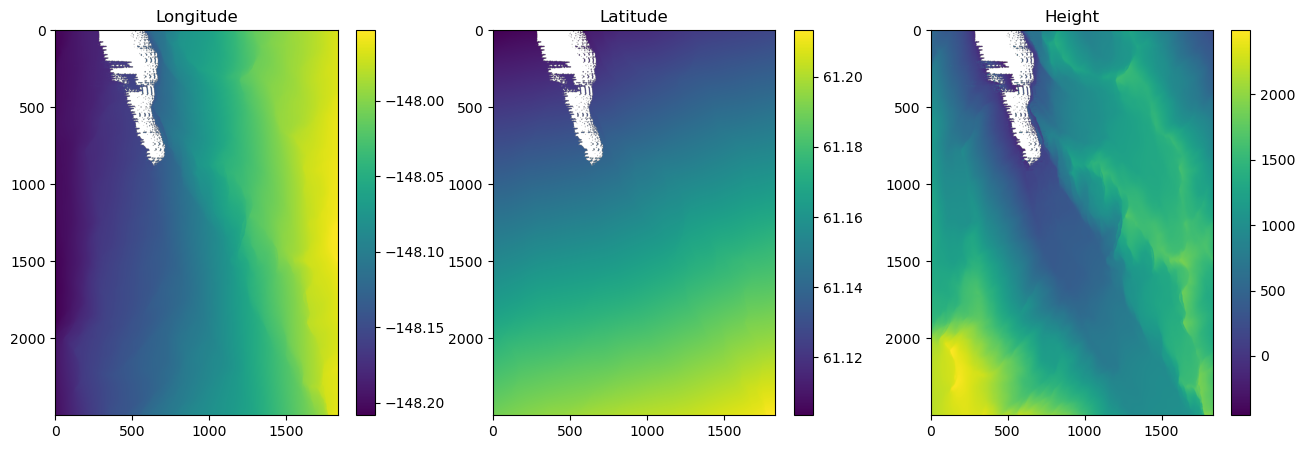

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(16,5))
im0 = axes[0].imshow(lon_data)
axes[0].set_title('Longitude')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(lat_data)
axes[1].set_title('Latitude')
fig.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(hgt_data)
axes[2].set_title('Height')
fig.colorbar(im2, ax=axes[2])
fig.show()

In [ ]:
#| export
@mc_logger
def load_gamma_look_vector(theta:str, # elevation angle
                           phi:str, # orientation angle
                           lt:str, # lookup table
                           rslc_par:str, # par file of the reference rslc
                           dem_par:str, # dem par
                           scratch_dir:str, # directory for preserve gamma intermediate files
                           theta_zarr:str, # output, elevation angle zarr
                           phi_zarr:str, # output, orientation angle zarr
                           chunks:tuple[int,int]=(1000,1000), # rslc chunk size
                          ):
    '''
    Load look vector (elevation angle and orientation angle) in map geometry
    from gamma binary format to look vector in radar geometry zarr file.
    The two input data should be generated with the `look_vector` gamma command.
    All data equal to 0 are replaced with nan.
    '''
    logger = logging.getLogger(__name__)
    geo_width = _geo_width_nlines(dem_par)[0]
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')

    theta_data = zarr.open(theta_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float32)
    phi_data = zarr.open(phi_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float32)

    scratch_dir = Path(scratch_dir)
    scratch_dir.mkdir(exist_ok=True)

    theta_rdc = scratch_dir/'theta_rdc'
    command = f'geocode {lt} {theta} {geo_width} {str(theta_rdc)} {rdc_width} {rdc_nlines} >> {scratch_dir/"gamma.log"}'
    if theta_rdc.exists():
        logger.info(f'{theta_rdc} exists. skip runing {command}')
    else:
        logger.info('run gamma command to generate elevation angle in range doppler coordinate:')
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
    logger.info('writing data.')
    theta_data[:] = read_gamma_image(theta_rdc,rdc_width,dtype='float')

    phi_rdc = scratch_dir/'phi_rdc'
    command = f'geocode {lt} {phi} {geo_width} {str(phi_rdc)} {rdc_width} {rdc_nlines} >> {scratch_dir/"gamma.log"}'
    if phi_rdc.exists():
        logger.info(f'{phi_rdc} exists. skip runing {command}')
    else:
        logger.info('run gamma command to generate orientation angle in range doppler coordinate:')
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
    logger.info('writing data.')
    phi_data[:] = read_gamma_image(phi_rdc,rdc_width,dtype='float')
    logger.info('Done.')

An example:

In [ ]:
lt = '../../data/gamma/geocoding/20210802.lt_fine'
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
dem_par = '../../data/gamma/DEM/dem_seg_par'
theta = '../../data/gamma/geocoding/20210802.lv_theta'
phi = '../../data/gamma/geocoding/20210802.lv_phi'
scratch_dir = './raw/scratch'
theta_zarr = './raw/theta.zarr'
phi_zarr = './raw/phi.zarr'

In [ ]:
load_gamma_look_vector(theta,phi,lt,rslc_par,dem_par,scratch_dir,theta_zarr,phi_zarr,chunks=(1000,1000))

2025-09-18 12:16:18 - log_args - INFO - running function: load_gamma_look_vector
2025-09-18 12:16:18 - log_args - INFO - fetching args:
2025-09-18 12:16:18 - log_args - INFO - theta = '../../data/gamma/geocoding/20210802.lv_theta'
2025-09-18 12:16:18 - log_args - INFO - phi = '../../data/gamma/geocoding/20210802.lv_phi'
2025-09-18 12:16:18 - log_args - INFO - lt = '../../data/gamma/geocoding/20210802.lt_fine'
2025-09-18 12:16:18 - log_args - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2025-09-18 12:16:18 - log_args - INFO - dem_par = '../../data/gamma/DEM/dem_seg_par'
2025-09-18 12:16:18 - log_args - INFO - scratch_dir = './raw/scratch'
2025-09-18 12:16:18 - log_args - INFO - theta_zarr = './raw/theta.zarr'
2025-09-18 12:16:18 - log_args - INFO - phi_zarr = './raw/phi.zarr'
2025-09-18 12:16:18 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:16:18 - log_args - INFO - fetching args done.
2025-09-18 12:16:18 - load_gamma_look_vector - INFO - image shape: (2500,1834

In [ ]:
theta_data = zarr.open(theta_zarr,mode='r')[:]
phi_data = zarr.open(phi_zarr,mode='r')[:]
# theta_data[theta_data==0] = np.nan
# phi_data[phi_data==0] = np.nan

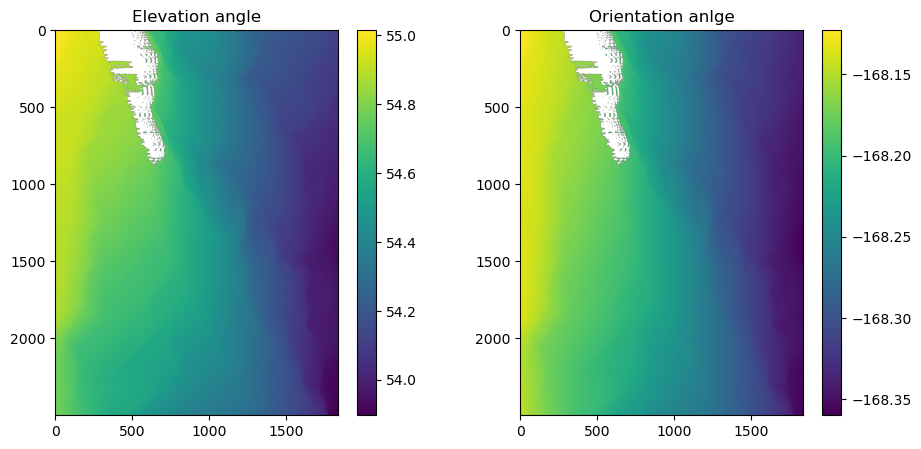

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(11,5))
im0 = axes[0].imshow(np.rad2deg(theta_data))
axes[0].set_title('Elevation angle')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(np.rad2deg(phi_data))
axes[1].set_title('Orientation anlge')
fig.colorbar(im1, ax=axes[1])
fig.show()

In [ ]:
#| export
@mc_logger
def load_gamma_range(rslc_par:str, # par file of one rslc
                     range_zarr:str, # output, range distance zarr
                     chunks:tuple[int,int]=(1000,1000), # rslc chunk size
                    ):
    '''
    Generate slant range distance and save to zarr.
    '''
    logger = logging.getLogger(__name__)
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')
    with open(rslc_par) as f:
        for line in f:
            if re.search('near_range_slc',line):
                rho0 = float(line.split()[1])
            if re.search('range_pixel_spacing',line):
                d_rho = float(line.split()[1])

    logger.info('Calculating slant range distance.')
    rho1d = np.arange(rdc_width)*d_rho+rho0
    rho2d = np.tile(rho1d,(rdc_nlines,1))
    range_data = zarr.open(range_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = chunks, dtype=np.float32)
    logger.info('writing data.')
    range_data[:] = rho2d
    logger.info('Done.')

An example:

In [ ]:
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
range_zarr = './raw/range.zarr'

In [ ]:
load_gamma_range(rslc_par,range_zarr)

2025-09-18 12:16:28 - log_args - INFO - running function: load_gamma_range
2025-09-18 12:16:28 - log_args - INFO - fetching args:
2025-09-18 12:16:28 - log_args - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2025-09-18 12:16:28 - log_args - INFO - range_zarr = './raw/range.zarr'
2025-09-18 12:16:28 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:16:28 - log_args - INFO - fetching args done.
2025-09-18 12:16:28 - load_gamma_range - INFO - image shape: (2500,1834)
2025-09-18 12:16:28 - load_gamma_range - INFO - Calculating slant range distance.
2025-09-18 12:16:28 - load_gamma_range - INFO - writing data.
2025-09-18 12:16:28 - load_gamma_range - INFO - Done.


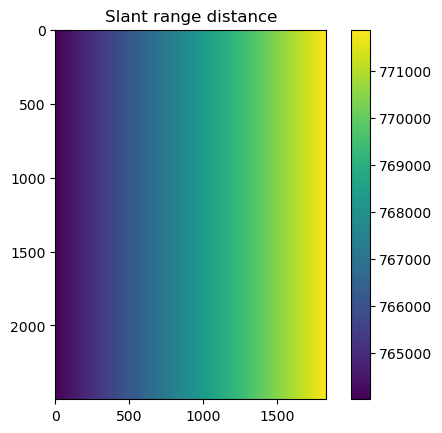

In [ ]:
range_data = zarr.open(range_zarr,mode='r')[:]
plt.imshow(range_data)
plt.colorbar()
plt.title("Slant range distance")
plt.show()

In [ ]:
#| export
@mc_logger
def load_gamma_metadata(rslc_dir:str, # gamma rslc directory, the name of the rslc and their par files should be '????????.rslc' and '????????.rslc.par'
                        dem_par:str, # dem par
                        reference:str, # reference date, eg: '20200202'
                        meta_file:str, # output, text toml file for meta data
                        ):
    '''
    Load necessary metadata into a toml file.
    '''
    meta = dict()
    rslc_dir = Path(rslc_dir)
    dates = []
    logger = logging.getLogger(__name__)
    for par_file in sorted(rslc_dir.glob('*.rslc.par')):
        dates.append(par_file.name[:8])
    meta['dates'] = dates

    logger.info('fetching slc related metadata.')
    with open(rslc_dir/(reference+'.rslc.par')) as f:
        for line in f:
            if re.search('radar_frequency',line):
                radar_f = float(line.split()[1])
                rdr_wavelen = speed_of_light/radar_f
                logger.info('Fetching randar wavelength')
            if re.search('heading',line):
                heading = float(line.split()[1])
                logger.info('Fetching heading angle')
            if re.search('range_pixel_spacing',line):
                dr = float(line.split()[1])
                logger.info('Fetching range pixel spacing')
            if re.search('azimuth_pixel_spacing',line):
                daz = float(line.split()[1])
                logger.info('fetching azimuth pixel spacing')

    meta['radar_wavelength'] = rdr_wavelen
    meta['range_pixel_spacing'] = dr
    meta['azimuth_pixel_spacing'] = daz

    logger.info('fetching dem related metadata')
    geo_width, geo_nlines = _geo_width_nlines(dem_par)
    cor_lat, cor_lon, pos_lat, pos_lon = _cor_pos_dem(dem_par)
    x0, xm = cor_lon, cor_lon+(geo_width-1)*pos_lon
    y0, ym = cor_lat+(geo_nlines-1)*pos_lat, cor_lat
    lonlat_bbox = [x0, y0, xm, ym]
    meta['lonlat_bbox'] = lonlat_bbox
    web_x0, web_xm = (lon*20037508.34/180 for lon in (x0, xm))
    web_y0, web_ym = (math.log(math.tan((90+lat)*math.pi/360))/(math.pi/180)*20037508.34/180 for lat in (y0, ym))
    meta['merca_bbox'] = [web_x0, web_y0, web_xm, web_ym]

    with tempfile.TemporaryDirectory() as temp_dir:        
        temp_dir = Path(temp_dir)
        slc_tab = temp_dir/'slc_tab'
        bperp = temp_dir/'bperp'
        itab = temp_dir/'itab'
        
        tab_content = ''
        for date in dates:
            tab_content += str(rslc_dir/(date+'.rslc'))
            tab_content += '      '
            tab_content += str(rslc_dir/(date+'.rslc.par'))
            tab_content += '\n'
        slc_tab.write_text(tab_content)

        logger.info('Run gamma command to calculate baseline:')
        command = f"base_calc {str(slc_tab)} {str(rslc_dir/(reference+'.rslc.par'))} {str(bperp)} {str(itab)} - > {temp_dir/'log'}"
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
        dat = pd.read_csv(bperp, sep=r'\s+', header=None)
        base=dat[3].to_numpy()
        base=base.astype(np.float32)

    meta['perpendicular_baseline'] = base

    with open(meta_file,'w') as f:
        a = toml.dump(meta,f,encoder=toml.TomlNumpyEncoder())
    logger.info('All meta data: \n'+a)
    logger.info('writing data in toml file.')
    logger.info('Done.')

An example:

In [ ]:
rslc_dir = '../../data/gamma/rslc'
dem_par = '../../data/gamma/DEM/dem_seg_par'
reference = '20220620'
meta_file = './raw/meta.toml'

In [ ]:
load_gamma_metadata(rslc_dir,dem_par,reference,meta_file)

2025-09-18 12:16:32 - log_args - INFO - running function: load_gamma_metadata
2025-09-18 12:16:32 - log_args - INFO - fetching args:
2025-09-18 12:16:32 - log_args - INFO - rslc_dir = '../../data/gamma/rslc'
2025-09-18 12:16:32 - log_args - INFO - dem_par = '../../data/gamma/DEM/dem_seg_par'
2025-09-18 12:16:32 - log_args - INFO - reference = '20220620'
2025-09-18 12:16:32 - log_args - INFO - meta_file = './raw/meta.toml'
2025-09-18 12:16:32 - log_args - INFO - fetching args done.
2025-09-18 12:16:32 - load_gamma_metadata - INFO - fetching slc related metadata.
2025-09-18 12:16:32 - load_gamma_metadata - INFO - Fetching heading angle
2025-09-18 12:16:32 - load_gamma_metadata - INFO - Fetching range pixel spacing
2025-09-18 12:16:32 - load_gamma_metadata - INFO - fetching azimuth pixel spacing
2025-09-18 12:16:32 - load_gamma_metadata - INFO - Fetching randar wavelength
2025-09-18 12:16:32 - load_gamma_metadata - INFO - fetching dem related metadata
2025-09-18 12:16:32 - load_gamma_meta

In [ ]:
with open(meta_file,'r') as f:
    meta_read = toml.load(f)

In [ ]:
meta_read

{'dates': ['20210802',
  '20210816',
  '20210830',
  '20210913',
  '20211011',
  '20211025',
  '20220606',
  '20220620',
  '20220704',
  '20220718',
  '20220801',
  '20220815',
  '20220829',
  '20220912',
  '20220926',
  '20221010',
  '20221024'],
 'radar_wavelength': 0.24245249210715603,
 'range_pixel_spacing': 4.29054,
 'azimuth_pixel_spacing': 3.740105,
 'lonlat_bbox': [-148.2606018,
  61.099475398661994,
  -147.89598577255998,
  61.2183333],
 'merca_bbox': [-16504294.694782883,
  8648700.085300261,
  -16463705.824278845,
  8676129.004166307],
 'perpendicular_baseline': [-97.61360168457031,
  -45.58580017089844,
  17.86680030822754,
  -26.258899688720703,
  -63.72420120239258,
  -56.363399505615234,
  64.75759887695312,
  0.0,
  -9.043999671936035,
  -13.02869987487793,
  -112.94960021972656,
  -86.09490203857422,
  -129.9635009765625,
  -127.6594009399414,
  -182.29519653320312,
  -129.735107421875,
  -184.31100463867188]}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()